In [16]:
# imports the libraries
import csv
from math import sqrt
import pandas as pd
from scipy import stats
import math
import numpy as np
import heapq
import random
from sklearn.preprocessing import MinMaxScaler
import time

In [17]:
data_path = ''

In [18]:
# builds the mock data set
input_file = csv.DictReader(open(f"{data_path}/DataSets/movieratings.csv"))
critics = {}
for row in input_file:
    key = row.pop('User')
    if not key in critics:
        critics[key] = {}
        for item in row:
            if row[item]!='':critics[key][item] = float(row[item])
                
#transform dict into pd.df once in the beginning instead of in every function call in order to save computing cost
critics = pd.DataFrame.from_dict(critics)

In [19]:
#100k movie lense dataset

headers = ['user id', 'item id', 'rating', 'timestamp'] 
rating_raw = pd.read_table(f'{data_path}/DataSets/extra/ml-100k/u.data', header=None, names=headers)
rating_raw.drop(['timestamp'], axis=1, inplace=True)

headers = ['movie id', 'movie title'] 
title = pd.read_table(f'{data_path}/DataSets/extra/ml-100k/u.item', encoding='latin-1', header=None, sep='|')
title = title.iloc[:, :2]
title.columns = ['MovieId', 'MovieTitle']
title["Movie"] = title['MovieId'].astype(str) + ': ' + title['MovieTitle']

critics_100k = rating_raw.merge(title, how='left', left_on='item id', right_on='MovieId')

critics_100k.drop(['item id', 'MovieId', 'MovieTitle'], axis=1, inplace=True)
critics_100k['user id'].astype(str)

critics_100k = critics_100k.pivot(index='Movie', columns='user id', values='rating')

### Computation of the Pearson Correlation

The following Cell computes the pearson Correlation of a given pair of Persons. The Correlation is hereby computed as a correlation dataframe using the .corr method included in Pandas. The pandas specific method is chosen over e.g. scipy.stats.pearsonr since it can handle the dataframe more efficiently for example in terms of NA values (The Pandas Method is overall a natural fit with Pandas Dataframes).

In [20]:
#%%timeit

def pearsonMatrix(prefs):
    """
    Computes the complete pearson correlation Matrix.
    """
    matrix = prefs.corr(method='pearson') #.corr computes pearson correlation of all inputted pairs and outputs in matrix
    return matrix #returns complete correlation matrix

def pearsonSimilarity(person1, person2, corrM):
    """
    Calls the desired pair of persons from the complete correlation Matrix.
    """
    similarity = corrM.loc[person1, person2] #.loc calls the desired pair of persons from the complete correlation Matrix
    return similarity #returns single correlation value

### Estimate Ratings and Extract Recommendations per User
In the following Cell the missing ratings are estimated for a given User. 

As for loops are usually a highly inefficient way of working with table data I aimed to make as many computations as possible in dataframe/ vector format.

In order to compute the V weights the complete correlation Matrix is passed to getRecommendations. I created a dictionary from the row of correlationts that represent the correlatin of all Vs with given U. This dictionary is then apended to the rating matrix as an additional row (index ='similarity_v').

I was following the formula of personalized & normalized collaborative filtering (S = sum((r - mean(rV))* w) / sum(w)). Therefore, I firstly needed to compute the product of all of V's ratings subtracted by V's rating mean and the similarity between U and the respective V for every item that is to be estimated. The rating is normalized by adding the mean rating as a new row to the dataframe and subtracting it in the iteration over all the estimation targets. Since we included W as 'similarity_v' in the main dataframe this figure needs to be multiplied with each row (representing the ratings per movie) of movie ratings. To do this I iterate over the movies that need to be estimated (not rated by U so far) and use these as index for the respectve vector multiplication. The sum of each iteration is then divided by the sum of the entire 'similarity_v' (division done as part of iteration). For each iteration the resulting score is inserted in the main dataframe for U & the respective movie in order to save memory power (in comparison to save it in e.g. an extra list).

The entire column U of the main matrix is then inputtet into a scaler (sklearn MinMaxScaler) in order to adapt tyhe estimations for the given 1-5 scale.

The not rated movienames as well as the estimations are then written into the desired output format (list of tuples).
In the final step this list is sorted (descending) and filtered for the top N results which represent the recommendations to U.

In [21]:
def getRecommendations(prefs,person, similarity_matrix):  
    """
    Computing an estimation for the missing rating for a given User U.
    """
    ## Appending Similarities (W) as weight row to main dataframe
    similarity_dict = {} #define dict with similarities to person
    for i in prefs.columns: similarity_dict[i] = similarity_matrix.loc[person, i] #append similarity of every user in main dataframe to dict
    prefs = prefs.append(pd.Series(similarity_dict,name='similarity_v')) #appending similarities of V & U as new row to main dataframe   
     
    ## Compute mean movie rating given by V in order to normalise later
    prefs.loc['mean_rating_v'] = prefs.mean(axis=0) #Compute V rating mean in new row
    
    ## Computing the sum of weights (Denominator in formula) 
    sum_of_v_weights = prefs.loc['similarity_v'].sum() #summing up the row entries in weight row
        
    ## Define list of movies that have not been rated by U and therefore need to be iterated
    not_rated = prefs[person][prefs[person].isna()].index #extract list of movies not rated by U (need to be estimated)
        
    ## Iterate movie names that have not been rated by U
    for m in not_rated: #for every movie that was not rated
        prefs.loc['normalised_rating'] = prefs.loc[m, :].values - prefs.loc['mean_rating_v'].values #compute normalised rating
        prefs.loc['weighted_rating'] = prefs.loc['normalised_rating'].values * prefs.loc['similarity_v', :].values #movie rating of V * Wvu (create new row / overwrite row with all results for movie m of iteration)           
        prefs.loc[m, person] = np.nansum(prefs.loc['weighted_rating'].values) / sum_of_v_weights #U score estimation by summing all weithed ratings, dividing by sum of weights & inserting in respective plave in U column
            
    ## Scale Estimated Ratings on the given scale of 0-5
    scaler = MinMaxScaler((0, 5)) #define scaler (sklearn package)
    prefs[person] = scaler.fit_transform(prefs[[person]]) #insert U column (containing estimations into scaler)
    
    ## Write Results in output format (List of Tuples)
    rankings = [] #define list to append tuples 
    for m in not_rated: rankings.append((prefs.loc[m, person], m)) #append estimated pair of movie name and estimated rating as tuple to list
                
    return sorted(rankings, reverse = True)[:10] #return sorted list of tuples (reverse = True for descending order)

### Neighbourhood Selection
The following cell computes the neighbourhood to user U that can then be considered to compute recommendations more efficiently.

##### Approach1:
To do this the complete similarity matrix is passed to the function. Then I sorted the matrix by the index respective to the name of U (Equal to a ranking). From this ranking the number of desired neighbourhood members is extracted from the dataframe. Ultimately, the colums of the leftover rankings are called and filtered for the top N.

##### Approach2:
The second approach uses a given threshold in order to select the neighbourhood. This threshold was selected as > .5 and < .-5 correlation in this case. (default on False due to bad test results)

In [22]:
def topMatches(prefs, similarity_matrix, person,n=10,neighbourhood_size=20, threshold_option=False, threshold=.5):
    """
    Computes neighbourhood of U that is inserted into getRecommendations & calls get Recommendations.
    """
    #if function for optional threshold
    if threshold_option == True:
        #check similarity matrixa against threshold and selct index as neighbourhood
        neighbourhood = similarity_matrix[abs(similarity_matrix.loc[person, :]) > threshold].index
        
        #define final dataframe with defined columns
        final_ratings = prefs.loc[:, neighbourhood]  
    
    elif threshold_option == False:
        #sorting values in the similarity matrix by row (axis 1) of respective person (ascending for ranking from high to low)
        similarity_matrix.sort_values(axis=1, by=person, inplace=True, ascending=False)
 
        #call columns of ranked neigbours(since U is also included)
        neighbourhood = similarity_matrix.columns[:neighbourhood_size+1]
        
        #define the final dataframe as all the columns until neighbourhood_size 
        final_ratings = prefs.loc[:, neighbourhood]
 
    return final_ratings

### Putting it together and calling the functions
The following cells defines a function that calls all the functions in the right order.
The function needs the dataset as well as the "mode" as input.

The function also measures the runtime in seconds. Final result for the sample dataset hereby 0.023 seconds and for the 100k dataset 3.208 seconds.

In [23]:
def run_recommender(prefs, mode):
    #### Run with Mock Dataset ####
    #start = time.perf_counter()
    print(f'Running for {mode} Dataset')
    
    #randomply choose a user from the selected dataset to estimate ratings for
    person_U = random.choice(prefs.columns)
    
    #compute complete correlation matrix
    corrMatrix = pearsonMatrix(prefs)

    #computing the neighbourhood of U
    final_neigh_matrix = topMatches(prefs, person=person_U, similarity_matrix=corrMatrix)

    #call getRecommendations function with neighbourhood dataframe
    recommendations = getRecommendations(prefs=final_neigh_matrix, person=person_U, similarity_matrix=corrMatrix)

    #print final results
    print(f'Recommendations for User {person_U}:')
    print(recommendations)

    #end = time.perf_counter()
    #print(f'Total Runtime: {end-start} seconds')
    return

run_recommender(critics, mode='Mock')
run_recommender(critics_100k, mode='100k')

Running for Mock Dataset
Recommendations for User 4489: Valery:
[(3.4536672646823403, '780: Independence Day (ID4) (1996)'), (2.9366979049586686, '2916: Total Recall (1990)'), (1.6663555021333516, '34: Babe (1995)'), (0.0, '3578: Gladiator (2000)')]
Running for 100k Dataset
Recommendations for User 470:
[(0.5931072832671631, '313: Titanic (1997)'), (0.5339781122946161, '333: Game, The (1997)'), (0.4677178978198913, '300: Air Force One (1997)'), (0.4498128249731095, '347: Wag the Dog (1997)'), (0.4363567112872689, '310: Rainmaker, The (1997)'), (0.4228478918151617, '332: Kiss the Girls (1997)'), (0.42239450943772927, '269: Full Monty, The (1997)'), (0.40805967233929913, '272: Good Will Hunting (1997)'), (0.3775855417754484, '350: Fallen (1998)'), (0.34137972832520513, '881: Money Talks (1997)')]


### Extra: Critics Regression Comparison (Scatter Plot)
The following cells firstly plot the movie ratings of two randomly chosen users from the database on a scatterplot. Secondly, the resulting scatterplot is validated computing the pearsonSimilarity between the users. As expected the result of the plot explains the pearsonCorrelation.

The Scatterplot of two User's ratings represents the similarity between the two respective users.
As more the regression of the pair is on one line in the plot as closer will be result of pearsonSimilarity be to 1 or - 1 (depending on the nature of the line). On the other side, as more clustered the regression is in the plot as closer will the regression be to 0.

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
corrMatrix = pearsonMatrix(critics_100k) 

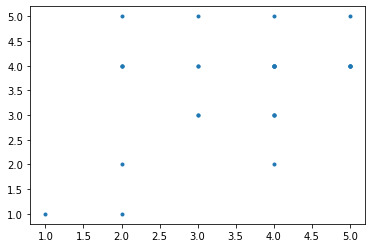

In [34]:
user1 = random.choice(critics_100k.columns) # choosing a random user 1 from the dataset
user2 = random.choice(critics_100k.columns) # choosing a random user 1 from the dataset
plt.plot(critics_100k[user1], critics_100k[user2], '.') #plotting the scatter of the rating of user1 & user2

In [35]:
pearsonSimilarity(user1, user2, corrMatrix) #compute the pearson correlation of user1 & user2 movie ratings

0.40402651703136505